<a href="https://colab.research.google.com/github/Hxrdik/Plant-Leaf-Disease-Detector/blob/main/Plant_Leaf_Diseases_Detection_%F0%9F%8D%83%F0%9F%8D%82.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing important libraries.
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'plantvillage:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3609458%2F6277996%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240419%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240419T155129Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D4dec1c16ce726bb437c1dee45a9280bf78e52c27dd28f89c81518a0f4a585a4b3d61f427f75ca543887ede9824a31ff9cf64d89674dfe5161b1eb328d2a6759090eae9b06f154b1b66351456769f8698041ae39c94127f5190d5329ac99abed129d9b69e592ef13e1a6322fff6d8e1974e13f4579ba2492d20a4f5385b80b38b35be165ff6010d3f34ba5960093b80e288a83a26d7b46b7d3184f8fccbf6ad208c0d15939e01090df77202ec9325532fb652a3517e74b96c81695712fa24c5270586663925bbc11e03ae6507c61b1a2089e93f0adc5bbabf74736d8bb9d8a910cd48eb99b71ae269e0626fba521f1d52b4755db0c08df84aacabc4fc9569166b'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 344545657 bytes downloaded
Downloaded and uncompressed: plantvillage
Data source import complete.


# Importing necessary libraries

**To achieve better results, upgrade TensorFlow to the latest version for performance improvements, bug fixes, and new features.**


In [ ]:
%%capture
# Use the %%capture magic command to hide output 'Installation process'

# Upgrade TensorFlow to the latest version
!pip install --upgrade tensorflow

In [ ]:
import os  # Operating system-specific functionality.
import matplotlib.pyplot as plt  # Plotting library for creating visualizations.
import numpy as np  # Numerical computing library for handling arrays and mathematical operations.
import matplotlib.image as mpimg  # Library for reading and displaying images.
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Part of TensorFlow for real-time data augmentation during model training.
import tensorflow as tf  # Deep learning framework.
from tensorflow.keras.models import Sequential  # Keras sequential model for building neural networks.
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout  # Keras layers for building neural networks.
from tensorflow.keras.callbacks import ModelCheckpoint  # Callback in Keras for saving the model during training.
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

# Setting random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

print("TensorFlow successfully updated to version:", tf.__version__)

TensorFlow successfully updated to version: 2.16.1


# Exploring the Dataset Contents


In [ ]:
# Setting the path to the dataset directory
dataset_path = r"/kaggle/input/plantvillage/dataset"

# Listing the contents (files and directories) of the  dataset
os.listdir(dataset_path)


['train', 'test', 'validation']

In [ ]:
# Creating path for the training subset of the dataset
train_path = os.path.join(dataset_path, 'train')

# Creating path for the validation subset of the dataset
validation_path = os.path.join(dataset_path, 'validation')

# Creating path for the test subset of the dataset
test_path = os.path.join(dataset_path, 'test')

# Distribution of Images in Each Folder

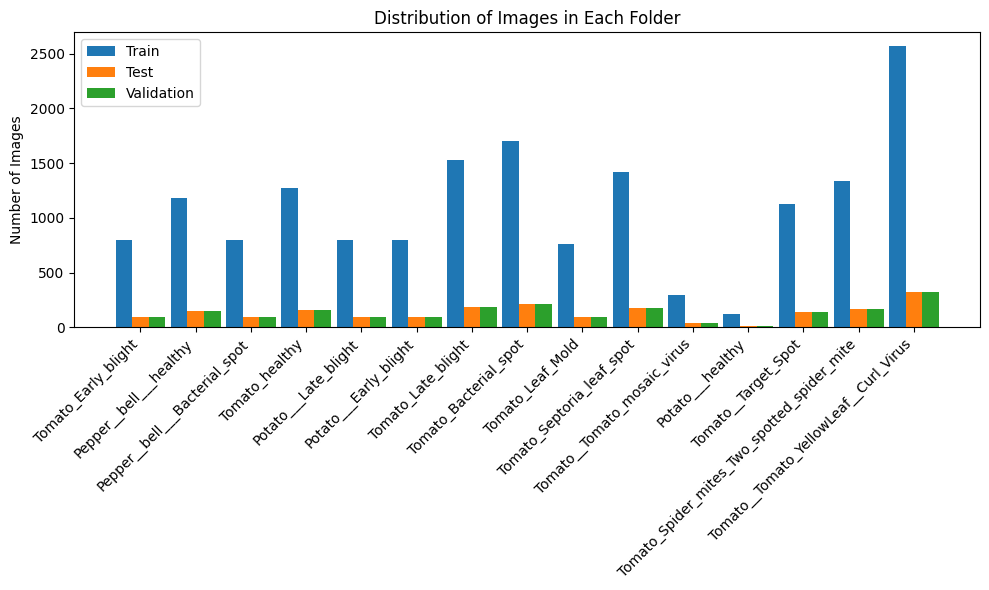

In [ ]:
# Defining the folders representing different subsets of the dataset
folders = ['train', 'test', 'validation']

# Dictionary to store the lengths of subfolders in each dataset subset
subfolder_lengths = {folder: {} for folder in folders}

# Iterating through each folder (train, test, validation)
for folder in folders:
    # Getting the list of subfolders within the current dataset subset
    subfolders = os.listdir(os.path.join(dataset_path, folder))

    # Iterating through each subfolder
    for subfolder in subfolders:
        # Calculating the number of files (images) in the current subfolder
        subfolder_length = len(os.listdir(os.path.join(dataset_path, folder, subfolder)))

        # Storing the subfolder length in the dictionary
        subfolder_lengths[folder][subfolder] = subfolder_length

# Extracting subfolder names and their respective lengths for plotting
subfolder_names = list(subfolder_lengths['train'].keys())
train_lengths = list(subfolder_lengths['train'].values())
test_lengths = list(subfolder_lengths['test'].values())
val_lengths = list(subfolder_lengths['validation'].values())

# Setting up parameters for the bar plot
x = np.arange(len(subfolder_names))
width = 0.3

# Creating a bar plot
fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width, train_lengths, width, label='Train')
rects2 = ax.bar(x, test_lengths, width, label='Test')
rects3 = ax.bar(x + width, val_lengths, width, label='Validation')

# Adding labels and legend to the plot
ax.set_ylabel('Number of Images')
ax.set_title('Distribution of Images in Each Folder')
ax.set_xticks(x)
ax.set_xticklabels(subfolder_names, rotation=45, ha='right')
ax.legend()

# Adjusting layout and displaying the plot
plt.tight_layout()
plt.show()


# Display Images from the Training Dataset

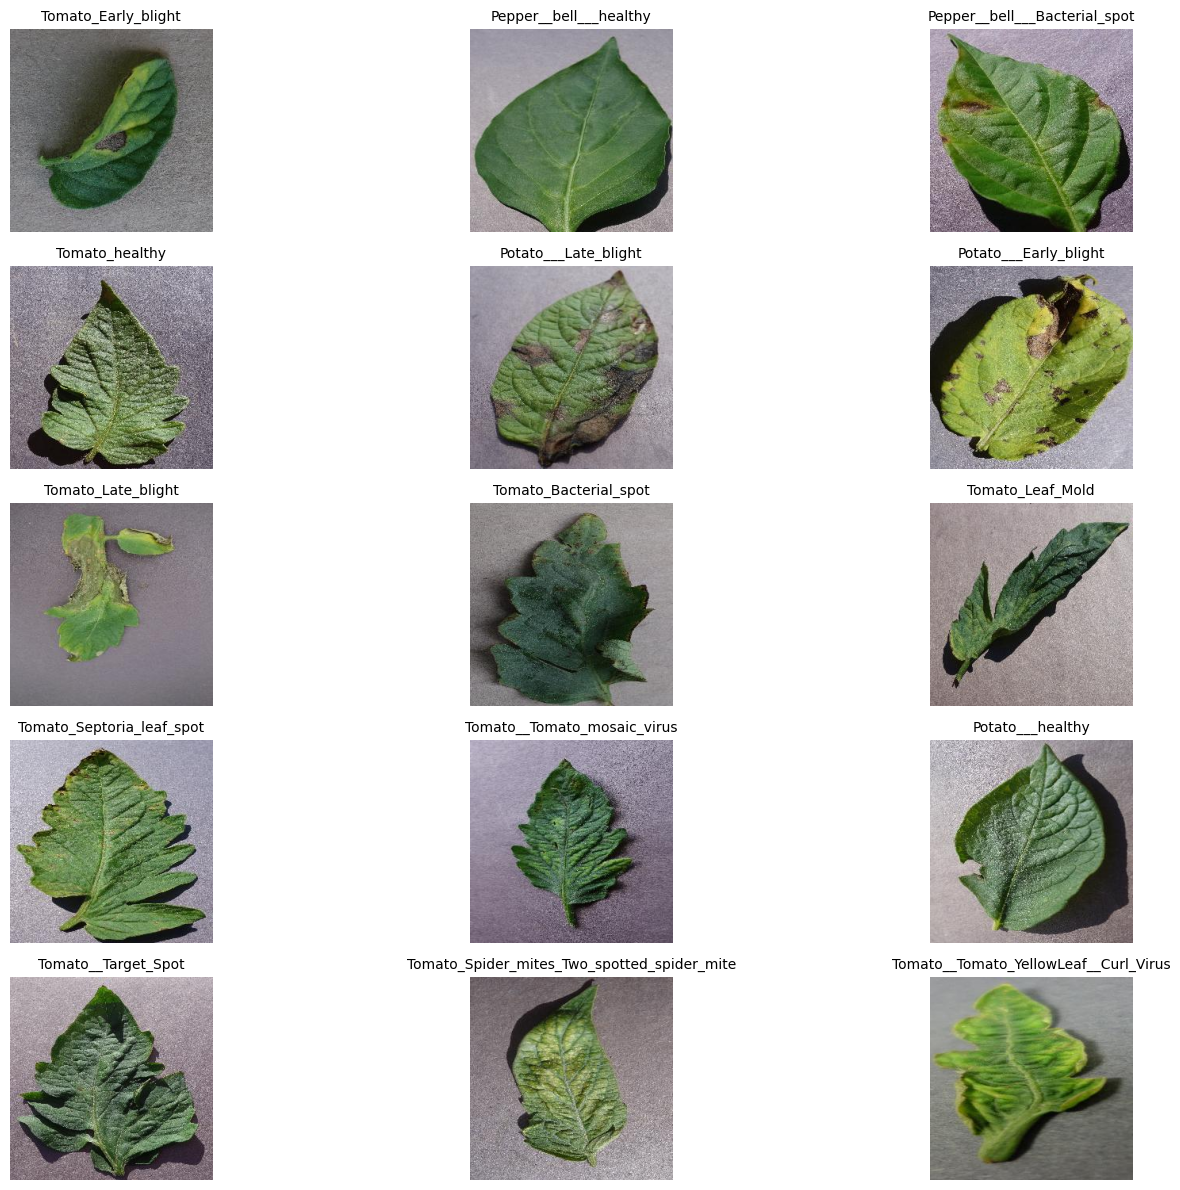

In [ ]:
# Create a grid to display the images
num_cols = 3  # Number of columns in the grid
num_rows = 5  # Number of rows in the grid

# Create a matplotlib figure and axis
fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 12))
axes = axes.ravel()  # Flatten the axes array for easier indexing

# Loop through subfolders and display an image from each
for i, subfolder in enumerate(subfolders):
    img = [image for image in os.listdir(os.path.join(train_path,subfolder))][0]

    img_path = os.path.join(train_path, subfolder, img)  # Get the first image in the subfolder
    img = mpimg.imread(img_path)  # Load the image
    axes[i].imshow(img)
    axes[i].axis('off')  # Turn off axis labels
    axes[i].set_title(subfolder, color='black', fontsize=10)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


# Image Data Augmentation for Training

In [ ]:
# Define batch size and image shape for data augmentation
batch_size = 32
image_shape = (256, 256)

# Create an ImageDataGenerator for training data augmentation
train_datagen = ImageDataGenerator(
    rescale=1/255,  # Rescale pixel values to the range [0, 1]
    shear_range=0.2,  # Apply shear transformation with a shear intensity of 0.2
    horizontal_flip=True,  # Randomly flip images horizontally
    vertical_flip=True,  # Randomly flip images vertically
    brightness_range=[0.5, 1.5],  # Adjust brightness between 50% and 150%
    rotation_range=40,  # Rotate images by up to 40 degrees
    zoom_range=0.2  # Randomly zoom into images by 20%
)

# Create a flow generator from the training directory using the defined data augmentation settings
train_generator = train_datagen.flow_from_directory(
    train_path,  # Path to the training dataset
    target_size=image_shape,  # Resize images to the specified shape
    batch_size=batch_size,  # Set the batch size
    class_mode="categorical"  # Use categorical mode for multi-class classification
)


Found 16504 images belonging to 15 classes.


In [ ]:
# Create an ImageDataGenerator for validation data without augmentation
validation_datagen = ImageDataGenerator(
    rescale=1/255  # Rescale pixel values to the range [0, 1]
)

# Create a flow generator from the validation directory
validation_generator = validation_datagen.flow_from_directory(
    validation_path,  # Path to the validation dataset
    target_size=image_shape,  # Resize images to the specified shape
    batch_size=batch_size,  # Set the batch size
    class_mode="categorical"  # Use categorical mode for multi-class classification
)


Found 2070 images belonging to 15 classes.


In [ ]:
# Create an ImageDataGenerator for test data without augmentation
test_datagen = ImageDataGenerator(
    rescale=1/255  # Rescale pixel values to the range [0, 1]
)

# Create a flow generator from the test directory
test_generator = test_datagen.flow_from_directory(
    test_path,  # Path to the test dataset
    target_size=image_shape,  # Resize images to the specified shape
    batch_size=batch_size,  # Set the batch size
    class_mode="categorical",  # Use categorical mode for multi-class classification
    shuffle=False  # Do not shuffle the data to preserve order for evaluation
)


Found 2064 images belonging to 15 classes.


# Convolutional Neural Network Architecture

In [ ]:
# Create a Sequential model
model = Sequential()

# Add a 2D convolutional layer with 32 filters, a 3x3 kernel, ReLU activation, and input shape of (256, 256, 3)
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))

# Add a max pooling layer with a 2x2 pool size
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add another 2D convolutional layer with 64 filters and a 3x3 kernel, followed by a ReLU activation
model.add(Conv2D(64, (3, 3), activation='relu'))

# Add another max pooling layer with a 2x2 pool size
model.add(MaxPooling2D(pool_size=(2, 2)))

# Repeat the pattern with two more convolutional layers and max pooling layers
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output to a one-dimensional array
model.add(Flatten())

# Add a dense layer with 512 units and ReLU activation
model.add(Dense(512, activation='relu'))

# Add a dropout layer with a dropout rate of 0.2 to prevent overfitting
model.add(Dropout(0.2))

# Add another dense layer with 128 units and ReLU activation
model.add(Dense(128, activation='relu'))

# Add the output layer with 15 units (for 15 classes) and softmax activation for multiclass classification
model.add(Dense(15, activation='softmax'))

# Compile the model using the Adam optimizer, categorical crossentropy loss, and accuracy as the metric
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy', metrics=['accuracy'])

# Define a ModelCheckpoint callback to save the best weights during training
checkpoint_callback = ModelCheckpoint("best_epoch_weights.keras", monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Display a summary of the model architecture
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 60, 60, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │       6,423,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 15)                  │           1,935 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,583,887 (25.12 MB)

 Trainable params: 6,583,887 (25.12 MB)

 Non-trainable params: 0 (0.00 B)

# Training the CNN Model

In [ ]:
# Calculate the number of steps per epoch for training and validation
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

# Set the number of training epochs
epochs = 30

# Train the model using the fit method with training and validation generators
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[checkpoint_callback]  # Include the ModelCheckpoint callback for saving the best weights
)

# Find the epoch with the best accuracy on the validation set
best_epoch = np.argmax(history.history['val_accuracy']) + 1

# Print the best epoch information
print(f"Best epoch is ==> epoch {best_epoch}")


Epoch 1/30
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 600ms/step - accuracy: 0.2859 - loss: 2.1825
Epoch 1: val_accuracy improved from -inf to 0.57422, saving model to best_epoch_weights.keras
515/515 ━━━━━━━━━━━━━━━━━━━━ 330s 610ms/step - accuracy: 0.2862 - loss: 2.1817 - val_accuracy: 0.5742 - val_loss: 1.2869
Epoch 2/30
  1/515 ━━━━━━━━━━━━━━━━━━━━ 39s 76ms/step - accuracy: 0.6875 - loss: 0.9412
Epoch 2: val_accuracy improved from 0.57422 to 0.72727, saving model to best_epoch_weights.keras
515/515 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6875 - loss: 0.9412 - val_accuracy: 0.7273 - val_loss: 1.1743
Epoch 3/30
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/step - accuracy: 0.6734 - loss: 0.9638
Epoch 3: val_accuracy improved from 0.72727 to 0.76465, saving model to best_epoch_weights.keras
515/515 ━━━━━━━━━━━━━━━━━━━━ 339s 551ms/step - accuracy: 0.6734 - loss: 0.9637 - val_accuracy: 0.7646 - val_loss: 0.7229
Epoch 4/30
  1/515 ━━━━━━━━━━━━━━━━━━━━ 29s 57ms/step - accuracy: 0.7812 - loss: 0.6694
E

# Load the weights of the best model

In [ ]:
# Set the best_model variable to the original model
best_model = model

# Compile the best_model using the Adam optimizer, categorical crossentropy loss, and accuracy as the metric
best_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Load the best weights saved during training
best_model.load_weights(r'best_epoch_weights.keras')

# Save the entire best_model (architecture and weights) to a file named "plant_leaf_diseases_model.h5"
best_model.save("plant_leaf_diseases_model.h5")

# Indicate that training is complete, and the best model has been saved
print("Training done, and the best model is saved.")


Training done, and the best model is saved.


# Model Evaluation on Test Set

In [ ]:
# Evaluate the best_model on the test data using the evaluate method
evaluation = best_model.evaluate(test_generator, verbose=0)

# Print the test accuracy and test loss rounded to 2 and 3 decimal places, respectively
print(f"Test Accuracy = {round(evaluation[1], 2)}")
print(f"Test Loss = {round(evaluation[0], 3)}")

Test Accuracy = 0.94
Test Loss = 0.175


# Training and Validation Performance Visualization

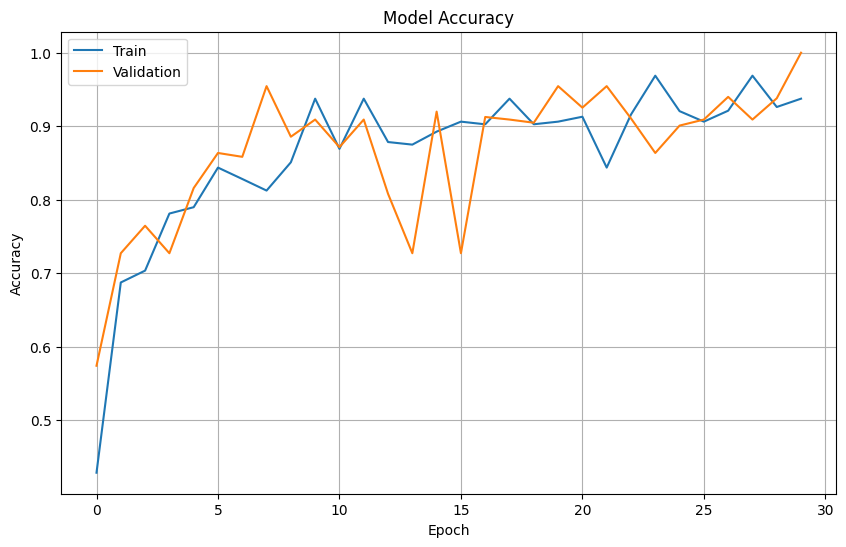

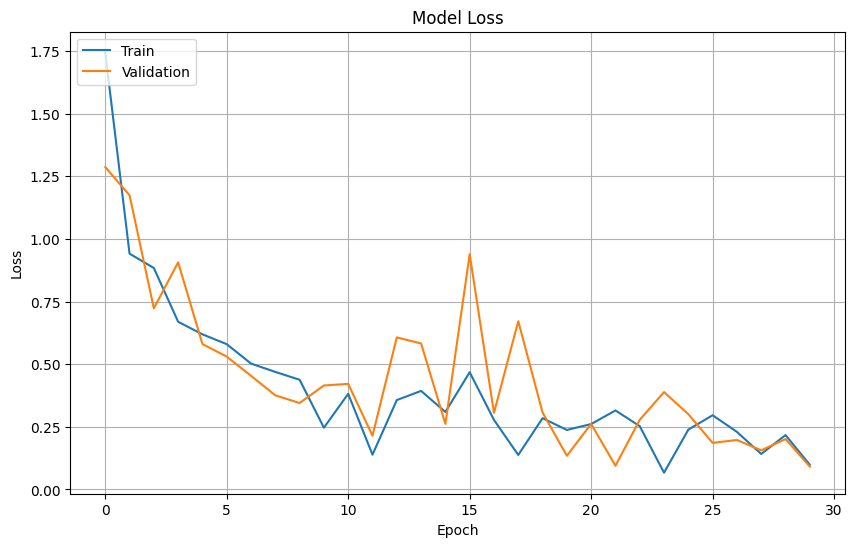

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)
plt.show()
